In [2]:
from z3 import *
from utils import *
from cardinality_constraints import *
import time

We define an auxiliar function in order to read the instance file

In [3]:
def read_instance(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        instance = {}
        instance["m"] = int(lines[0].strip())
        instance["n"] = int(lines[1].strip())
        instance["l"] = [int(x) for x in lines[2].strip().split()]
        instance["s"] = [int(x) for x in lines[3].strip().split()]
        instance["D"] = []

        for line in lines[4:]:
            distances = [int(x) for x in line.split()]
            instance["D"].append(distances)

        return instance

We read the first instance

In [18]:
path = '/Users/alessiopittiglio/projects/cdmo_project/'
file_path = path + "Instances/inst01.dat"
instance = read_instance(file_path)

In [19]:
import pprint
# pprint.pp(instance)

In [20]:
def smt_model(m, n, s, l, D,  implied_constraint = False, search='binary', timeout_duration = None):
    start_time = time.time()

    # Decision variables
    x = [[Bool(f"x_{i}_{j}") for j in range(n)] for i in range(m)]  # x[i, j]: courier i delivers item j
    y = [[[Bool(f"y_{i}_{j}_{k}") for k in range(n + 1)] for j in range(n + 1)] for i in range(m)]  # y[i, j, k]: courier i travels from j to k
    u = [[Int(f"u_{i}_{j}") for j in range(n + 1)] for i in range(m)]  # u[i, j]: position of item j in the tour of courier i

    solver = Solver()

    # Constraints
    # 1. Load capacity constraints
    for i in range(m):
        solver.add(Sum([If(x[i][j], s[j], 0) for j in range(n)]) <= l[i])

    # 2. Each item must be assigned to exactly one courier
    for j in range(n):
        solver.add(exactly_one_seq([x[i][j] for i in range(m)], f"assign_item_{j}"))

    # 3. Route constraints: each courier's tour must start and end at the origin
    for i in range(m):
        # Start at the origin
        solver.add(exactly_one_seq([y[i][n][k] for k in range(n)], f"start_{i}"))
        # End at the origin
        solver.add(exactly_one_seq([y[i][k][n] for k in range(n)], f"end_{i}"))
    
        for j in range(n):
            # If a courier visits an item, it must leave that item
            solver.add(Sum([If(y[i][j][k], 1, 0) for k in range(n + 1)]) == If(x[i][j], 1, 0))
            # If a courier arrives at an item, it must leave from that item
            solver.add(Sum([If(y[i][k][j], 1, 0) for k in range(n + 1)]) == If(x[i][j], 1, 0))

    # 4. Ensure no single-node loops
    for i in range(m):
        for j in range(n + 1):
            solver.add(y[i][j][j] == False)
        
    # 5. Subtour elimination constraints (Miller-Tucker-Zemlin formulation)
    for i in range(m):
        for j in range(1, n + 1):
            solver.add(And(u[i][j] >= 1, u[i][j] <= n))
    
        for j in range(n):
            for k in range(n + 1):
                if j != k:
                    solver.add(Implies(y[i][j][k], u[i][j] + 1 == u[i][k]))
                    
        for k in range(n):
            solver.add(Implies(y[i][n][k], u[i][k] == 1))
    
    # 6. Define the maximum distance traveled by any courier
    max_distance = Int('max_distance')

    distances = [Sum([If(y[i][j][k], D[j][k], 0) for j in range(n + 1) for k in range(n + 1)]) for i in range(m)]
    for i in range(m):
        solver.add(distances[i] <= max_distance)

    encoding_time = time.time()
    timeout = encoding_time + timeout_duration

    low = 0
    high = sum(max(row) for row in D)  # Initial upper bound

    if search == 'linear':
        solver.push()
        solver.set('timeout', millisecs_left(time.time(), timeout))
        while solver.check() == sat:
            best_solution = solver.model()
            best_max_distance = obj_function(best_solution, m, D, y)

            if best_max_distance.as_long() <= low:
                break

            high = best_max_distance.as_long() - 1
            solver.pop()
            solver.push()

            for i in range(m):
                solver.add(max_distance <= high)
            
            now = time.time()
            if now >= timeout:
                break
            solver.set('timeout', millisecs_left(now, timeout))

    elif search == 'binary':
        # Binary search for minimizing the maximum distance
        best_solution = None
        best_max_distance = None
        while low <= high:
            mid = (low + high) // 2
            solver.push()
            now = time.time()
            if now >= timeout:
                break
            solver.set('timeout', millisecs_left(now, timeout)) 

            solver.add(max_distance <= mid)
            if solver.check() == sat:
                best_solution = solver.model()
                best_max_distance = obj_function(best_solution, m, D, y)
                high = mid - 1
            else:
                low = mid + 1
            solver.pop()
            
    end_time = time.time()
    if end_time >= timeout:
        solving_time = timeout_duration
    else:
        solving_time = math.floor(end_time - encoding_time)

    if best_solution:
        routes_true = []
        print(best_max_distance)
        for i in range(m):
            items = [j for j in range(n) if is_true(best_solution.evaluate(x[i][j]))]
            print(f"Courier {i + 1} delivers items: {items}")
            route = []
            for j in range(n + 1):
                for k in range(n + 1):
                    if is_true(best_solution.evaluate(y[i][j][k])):
                        route.append((j, k))
            routes_true.append(route)
            print(f"Route of courier {i + 1}: {route}")
    
    if best_solution is None:
        ans = "N/A" if solving_time == timeout_duration else "UNSAT"
        return (ans, solving_time, None)
    else:
        routes = []
        for i in range(m):
            arcs = []
            for j in range(n + 1):
                for k in range(n + 1):
                    if is_true(best_solution.evaluate(y[i][j][k])):
                        arcs.append((j + 1, k + 1))

            route = []
            current_node = n + 1
            while arcs:
                for arc in arcs:
                    if arc[0] == current_node:
                        route.append(arc[1])
                        current_node = arc[1]
                        arcs.remove(arc)
                        break

            if route and route[-1] == n + 1:
                route.pop(-1)

            routes.append(route)

        return routes_true

14
Courier 1 delivers items: [0, 2, 3]
Route of courier 1: [(0, 6), (2, 0), (3, 2), (6, 3)]
Courier 2 delivers items: [1, 4, 5]
Route of courier 2: [(1, 4), (4, 5), (5, 6), (6, 1)]


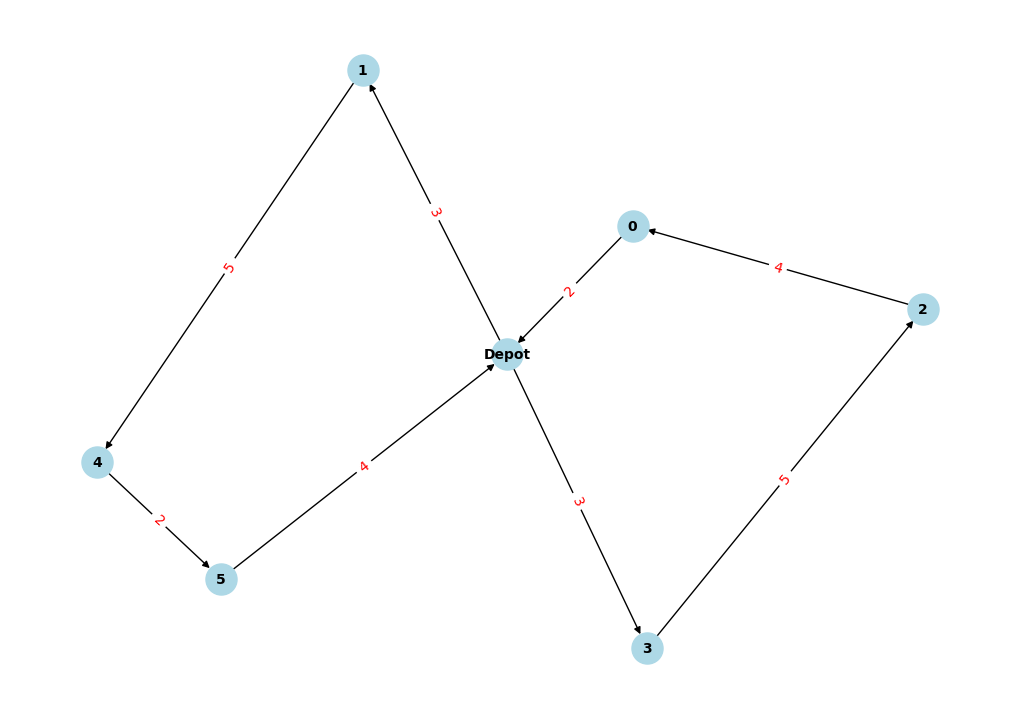

CPU times: user 742 ms, sys: 45.9 ms, total: 788 ms
Wall time: 597 ms


In [21]:
%%time
display_routing(smt_model(instance["m"], instance["n"], instance["s"], instance["l"], instance["D"], implied_constraint = True, timeout_duration=20), D = instance["D"])

In [15]:
def leq_same_digits(v, u, digits):
    assert(len(v) == len(u) and len(u) == digits)
    if digits == 1:
        return Or(v[0]==u[0], And(Not(v[0]), u[0]))
    else:
        return Or(And(Not(v[0]), u[0]),
                  And(v[0]==u[0], leq_same_digits(v[1:], u[1:], digits-1)))


def leq(v, u):
    digits_v = len(v)
    digits_u = len(u)

    if digits_v == digits_u:
        return leq_same_digits(v, u, digits_v)
    elif digits_v < digits_u:
        delta_digits = digits_u - digits_v
        return Or(Or(u[:delta_digits]),
                  leq_same_digits(v, u[delta_digits:], digits_v))
    else:
        delta_digits = digits_v - digits_u
        return And(all_false(v[:delta_digits]), leq_same_digits(v[delta_digits:], u, digits_u))

def all_false(v):
    return And([Not(v[k]) for k in range(len(v))])

def equal(v, u):
    assert(len(v) == len(u))
    return And([v[k]==u[k] for k in range(len(v))])

def sum_bin(a_bin, b_bin, d_bin, name):
    digits_a = len(a_bin)
    digits_b = len(b_bin)
    digits_d = len(d_bin)
    assert (digits_a <= digits_b and digits_b == digits_d)

    delta_digits = digits_b - digits_a

    if delta_digits == 0:
        formula, last_carry = sum_bin_same_digits(a_bin, b_bin, d_bin,
                                                  digits_a, name)
        return And(formula, Not(last_carry))  # imposing no overflow

    sub_sum_formula, last_carry = sum_bin_same_digits(a_bin,
                                                      b_bin[delta_digits:],
                                                      d_bin[delta_digits:],
                                                      digits_a, name)
    c = [Bool(f"c_propagated_{k}_{name}")
         for k in range(delta_digits)] + [last_carry]
    c[0] = False  # imposing no further overflow

    clauses = []
    for k in range(delta_digits - 1, -1, -1):
        clauses.append(d_bin[k] == Xor(b_bin[k], c[k + 1]))
        clauses.append(c[k] == And(b_bin[k], c[k + 1]))

    return And(And(clauses), sub_sum_formula)

def sum_bin_same_digits(a_bin, b_bin, d_bin, digits, name):
    # c_k represents carry at bit position k
    c = [Bool(f"c_{k}_{name}") for k in range(digits + 1)]
    c[-1] = False

    clauses = []
    for k in range(digits - 1, -1, -1):
        clauses.append((a_bin[k] == b_bin[k]) == (c[k + 1] == d_bin[k]))
        clauses.append(c[k] == Or(And(
            a_bin[k], b_bin[k]), And(a_bin[k], c[k +
                                                 1]), And(b_bin[k], c[k + 1])))

    formula = And(clauses)
    return (formula, c[0])


def conditional_sum_K_bin(x, alpha, delta, name):
    n = len(x)
    digits = len(delta)

    # matrix containing temporary results of sum_bin
    d = [[Bool(f"d_{j}_{k}_{name}") for k in range(digits)] for j in range(n - 1)]  # j = 1..n-1 because last row will be delta
    d.append(delta)

    clauses = []

    # row 0
    diff_digits = digits - len(alpha[0])
    assert (diff_digits >= 0)
    clauses.append(
        And(
            Implies(
                x[0],
                And(all_false(d[0][:diff_digits]),
                    equal(d[0][diff_digits:], alpha[0]))
            ),  # If x[0] == 1 then d_0 == alpha_0 (with eventual padding of zeros)
            Implies(Not(x[0]),
                    all_false(d[0]))))  # elif x[0] == 0 then d_0 == [0..0]

    # row j>1
    for j in range(1, n):
        clauses.append(
            And(
                Implies(x[j],
                        sum_bin(alpha[j], d[j - 1], d[j], f"{name}_{j-1}_{j}")
                        ),  # If c_j == 1 then d_j == d_j-1 + alpha_j
                Implies(Not(x[j]), equal(d[j], d[j - 1]))))

    return And(clauses)


x = [Bool(f"x_{i}") for i in range(5)]
y = [Bool(f"y_{i}") for i in range(4)]

conditional_sum_K_bin(x, [[True, True], [True, False], [True, True, False], [True, False, True], [True, False, False]], y, 'example')


s = Solver()
s.add(conditional_sum_K_bin(x, [[True, True], [True, False], [True, True, False], [True, False, True], [True, False, False]], y, 'example'))
s.check()
print(s.model())

[x_2 = False,
 d_1_1_example = False,
 c_2_example_2_3 = True,
 d_3_2_example = False,
 d_2_3_example = False,
 d_2_0_example = False,
 c_1_example_0_1 = False,
 c_1_example_2_3 = True,
 y_3 = False,
 c_2_example_1_2 = False,
 d_0_3_example = False,
 d_1_2_example = False,
 d_0_1_example = False,
 y_2 = False,
 y_1 = False,
 x_3 = False,
 c_0_example_0_1 = True,
 c_0_example_1_2 = True,
 c_1_example_1_2 = False,
 d_3_1_example = False,
 d_3_0_example = False,
 c_2_example_3_4 = True,
 d_3_3_example = False,
 c_0_example_2_3 = False,
 x_0 = False,
 d_0_0_example = False,
 c_0_example_3_4 = True,
 d_1_3_example = False,
 d_0_2_example = False,
 x_1 = False,
 d_2_1_example = False,
 y_0 = False,
 x_4 = False,
 c_propagated_1_example_0_1 = False,
 d_1_0_example = False,
 d_2_2_example = False,
 c_1_example_3_4 = False]


In [ ]:
from pysat.formula import CNF
from pysat.solvers import Glucose42

cnf_file = "problem.cnf"
formula = CNF(from_file=cnf_file)
solver = Glucose42()
solver.append_formula(formula)
sat = solver.solve()
if sat:
    model = solver.get_model()
    assignment = {abs(lit): (lit > 0) for lit in model}
    print("SAT", assignment)
else:
    print("UNSAT", None)

In [ ]:
class IncrementalPBEncoder:
    def __init__(self, bool_vars, coeffs, name, solver):
        self.bool_vars = bool_vars
        self.coeffs = coeffs
        self.name = name
        self.solver = solver
        self.max_distance = None
        self.outlits = []

    def encode(self, max_distance):
        self.max_distance = max_distance
        self.outlits = []
        
        for k in range(len(self.bool_vars)):
            outlits_k = [[Bool(f"s_{self.name}_{k}_{i}_{j}") for j in range(max_distance + 1)] for i in range(len(self.bool_vars[k]) + 1)]
            self.outlits.append(outlits_k)
            constraints = []

            n = len(self.bool_vars[k])
            for i in range(1, n + 1):
                wi = self.coeffs[i - 1]
                for j in range(1, max_distance + 1):
                    if i >= 2 and i <= n and j <= max_distance:
                        constraints.append(Or(Not(outlits_k[i - 1][j]), outlits_k[i][j]))
                    if i <= n and j <= wi:
                        constraints.append(Or(Not(self.bool_vars[k][i - 1]), outlits_k[i][j]))
                    if i >= 2 and i <= n and j <= max_distance - wi:
                        constraints.append(Or(Not(outlits_k[i - 1][j]), Not(self.bool_vars[k][i - 1]), outlits_k[i][j + wi]))
                if i >= 2:
                    constraints.append(Or(Not(outlits_k[i - 1][max_distance + 1 - wi]), Not(self.bool_vars[k][i - 1])))
    
            for constraint in constraints:
                self.solver.add(constraint)

    def update_max_distance(self, new_max_distance):
        if new_max_distance < self.max_distance:
            self.max_distance = new_max_distance
            for k in range(len(self.bool_vars)):
                self.solver.add(Not(self.outlits[k][len(self.bool_vars[k])][new_max_distance + 1]))  # tighten the constraint

    def is_satisfiable(self):
        return self.solver.check() == sat

D = [0, 10, 15, 20 10, 0, 35, 25, 15, 35, 0, 30, 20, 25, 30, 0]

x = [[Bool(f"x_{i}_{j}") for j in range(4)] for i in range(4)]
print(x)

solver = Solver()

initial_max_distance =  sum(max(row) for row in D)
encoder = IncrementalPBEncoder(x, D, "distance", solver)
encoder.encode(initial_max_distance)

min_distance = initial_max_distance
best_solution = None
best_max_distance = None
while True:
    if encoder.is_satisfiable() and min_distance > 0:
        best_solution = encoder.solver.model()
        min_distance -= 1
        encoder.update_max_distance(min_distance)
    else:
        min_distance += 1
        best_max_distance = min_distance
        break

print("Il minimo valore di max_distance è:", best_max_distance)